# Makemore Part 3

## Implementing a Language Model from Scratch:

In this notebook, I have tried to implement the part 3 of Andrej Karpathy's `Makemore` series, and my notes from the lecture.

In [2]:
# imports
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [3]:
# Read Data
words = open(r'../names.txt', 'r').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# Building vocabulary and Basic Character encoding and decoding

chars = sorted(list(set(''.join(words)))) # Get all the unique chars in sorted order

stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print("itos: ", itos)
print("Vocab Size is: ", vocab_size)

itos:  {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab Size is:  27


### Building the Dataset

Since this is a character level language model, we will be predicting the next in a sequence of some `block_size` elements. That is, if `block_size=3`, then our model will be predicting the fourth letter in a sequence of three characters. You can think of block size as the context length.

In [5]:
block_size = 3 

def build_dataset(words):
    X, Y = [ ], [ ]

    for w in words:
        context = [0] * block_size # For start of the word, have a padded context
        for char in w + ".":
            idx = stoi[char]
            X.append(context)
            Y.append(idx)

            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y

In [6]:
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words=words[:n1])
X_val, Y_val = build_dataset(words=words[n1:n2])
X_test, Y_test = build_dataset(words=words[n2:])

print("Train sizes: ", X_train.shape, Y_train.shape)
print("Validation Sizes: ", X_val.shape, Y_val.shape)
print("Test Sizes: ", X_test.shape, Y_test.shape)

Train sizes:  torch.Size([182625, 3]) torch.Size([182625])
Validation Sizes:  torch.Size([22655, 3]) torch.Size([22655])
Test Sizes:  torch.Size([22866, 3]) torch.Size([22866])


### Revisiting MLP Code

In [8]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)


parameters = [C, W1, b1, W2, b2]
print("Total Parameters: ", sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

Total Parameters:  11897


In [8]:
epochs = 20000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/  20000: 27.8817
   1000/  20000: 4.2419
   2000/  20000: 2.9765
   3000/  20000: 2.9278
   4000/  20000: 2.2592
   5000/  20000: 2.3338
   6000/  20000: 2.3778
   7000/  20000: 2.6701
   8000/  20000: 2.4029
   9000/  20000: 2.5651
  10000/  20000: 2.8244
  11000/  20000: 1.8802
  12000/  20000: 2.1443
  13000/  20000: 2.1793
  14000/  20000: 2.8686
  15000/  20000: 2.1322
  16000/  20000: 2.3923
  17000/  20000: 2.4342
  18000/  20000: 2.2146
  19000/  20000: 2.3063


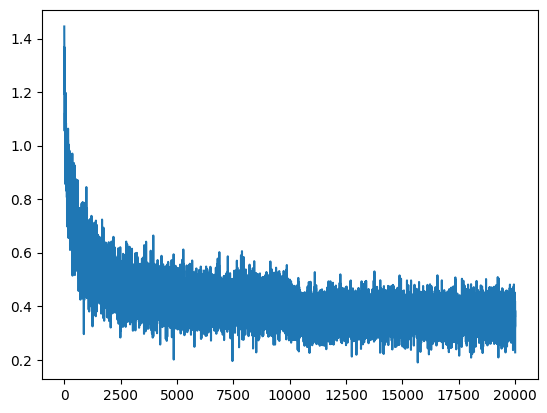

In [9]:
plt.plot(lossi)

In [12]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [X_train, Y_train], 
        'test': [X_test, Y_test], 
        'val': [X_val, Y_val]
    }[split]

    embeddings = C[x]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1)
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y) # PyTorch will apply softmax internally

    print(f"For {split}, loss was: {loss.item()}")

In [ ]:
split_loss('train')
split_loss('val')

For train, loss was: 2.309889316558838
For val, loss was: 2.323052406311035


##### Predictions Using the Model

In [11]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = [ ]
    context = [0] * block_size

    while True:

        embeddings = C[torch.tensor([context])]
        h = torch.tanh(embeddings.view(1, -1) @ W1  + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        idx = torch.multinomial(probs, num_samples=1, generator=g).item()

        context = context[1:] + [idx]

        out.append(idx)

        if idx == 0:
            break

    print("".join(itos[i] for i in out))

mri.
almyah.
see.
madheyah.
rehmancendra.
graderedielii.
shy.
jen.
ede.
sestanar.
katelostter.
noshibergahimies.
kinde.
jelionn.
puor.
uzzeyne.
ryy.
julieh.
ylue.
masteyah.


**Pro Tip:**

When training neural networks, you should always have a rough intuition of what the loss should be at initialization. Think in terms of what the problem is and what the model setup is to get an idea of this. Do some research online also. For example, in the MLP case, **at initialization**, we don't have any reason to believe that our model should assign higher probability to any of the characters. Thus, initially, the probabilities assigned to each character should be equal- $1/27$. Since the loss is negative log likelihood, the loss we should expect at initialization is: $-torch.tensor(1/27.0).log()=3.295$

### Better Initialization

Notice how the actual loss is way worse than the expected loss. So, there's something wrong with the initialization. Ideally, we want the `logits` ( the final layer values before we apply softmax ) to be roughly equal for all characters, because that will give us roughly uniform probabilities for all characters, i.e. the loss that we expect. At the moment, the logits are taking extreme values which is giving high initial loss. See the below cell for an example of this.

In [12]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 1
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

print("Loss: ", loss.item())
print("Logits: ", logits[0])

Loss:  28.149959564208984
Logits:  tensor([  0.3833,  -0.9662,   4.8501,   0.2882,  10.2159,  -5.0392,  -7.2439,
        -19.5775,  11.4931,   7.8832, -10.7001,   4.9914, -35.7654,   5.5013,
          2.9127,  15.7696,   3.0974,  -5.5875, -15.2168,   2.1749,   2.5613,
          9.4574,  18.6816, -15.0341,   1.1712,  21.4299,  -8.5857],
       grad_fn=<SelectBackward0>)


#### How to Get Logits Closer to Zero?

Since `logits = activations * W2 + b2`, we can reduce the values of $b2 and W2$ at initialization so that logits don't take randomly extreme values.

In [13]:
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Make W2 smaller
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # Make b2 smaller

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

epochs = 1
batch_size = 32
lossi = []

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(
        embeddings.shape[0], -1)  # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2  # Output layer

    # PyTorch will apply softmax internally
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

print("Loss: ", loss.item())

Loss:  3.306351661682129


The loss is much closer to what we expect. 

But **Pro Tip:** You don't want the weights of the neural net to be zero. You want them to be small but not zero.

Let's let the training run to see how loss behaves now with this improved initialization.

In [14]:
C = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # Make W2 smaller
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # Make b2 smaller

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

epochs = 20_000
batch_size = 32
lossi = []

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(
        embeddings.shape[0], -1)  # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2  # Output layer

    # PyTorch will apply softmax internally
    loss = F.cross_entropy(logits, y_batch)

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print("Loss: ", loss.item())

      0/  20000: 3.3107


   1000/  20000: 2.5355
   2000/  20000: 2.4904
   3000/  20000: 2.4003
   4000/  20000: 2.7225
   5000/  20000: 2.6738
   6000/  20000: 1.9511
   7000/  20000: 2.4856
   8000/  20000: 2.1792
   9000/  20000: 2.0987
  10000/  20000: 2.3935
  11000/  20000: 2.1975
  12000/  20000: 2.2624
  13000/  20000: 2.1243
  14000/  20000: 1.8139
  15000/  20000: 2.2433
  16000/  20000: 1.9484
  17000/  20000: 1.9300
  18000/  20000: 2.0046
  19000/  20000: 2.2269
Loss:  1.7531856298446655


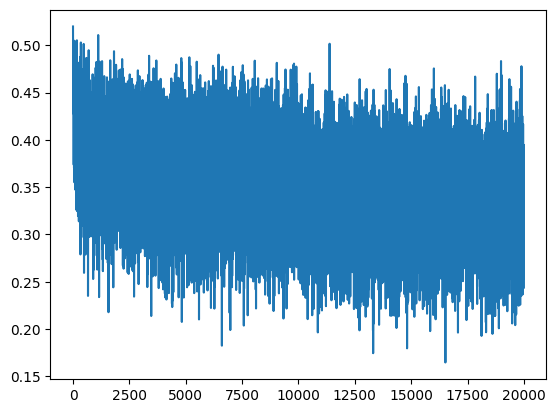

In [15]:
plt.plot(lossi)

In [16]:
split_loss('train'), split_loss('val')

For train, loss was: 2.170548677444458
For val, loss was: 2.1972811222076416


(None, None)

The previous loss was around 2.3 and now it is slightly improved. Think about this: In the initial epochs, the model was squishing down the values of W2 and b2 and that was wasting epochs. But now, since we've already initialized them to lower values, these initial epochs are not wasted- as evidenced by the two loss plots.

### Improving Tanh

In [17]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 1
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    break

print("activations: ", activations)

activations:  tensor([[-0.9962, -0.2811, -0.9994,  ..., -0.9861,  0.9815, -0.8938],
        [ 0.9927, -0.0759, -0.9968,  ..., -1.0000, -1.0000,  0.9782],
        [ 1.0000, -0.9994,  0.8448,  ...,  0.9999,  0.9756,  0.9638],
        ...,
        [-0.9999,  0.9988, -1.0000,  ...,  0.6431, -0.0060, -0.9988],
        [ 0.7632,  0.9706, -0.9625,  ..., -1.0000, -0.9768, -0.1925],
        [-0.9649, -0.8281,  0.9957,  ..., -0.8579, -0.9918, -0.9999]],
       grad_fn=<TanhBackward0>)


(array([65.,  5.,  1.,  1.,  3.,  4.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  2.,  3.,  3.,  4.,  7., 85.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

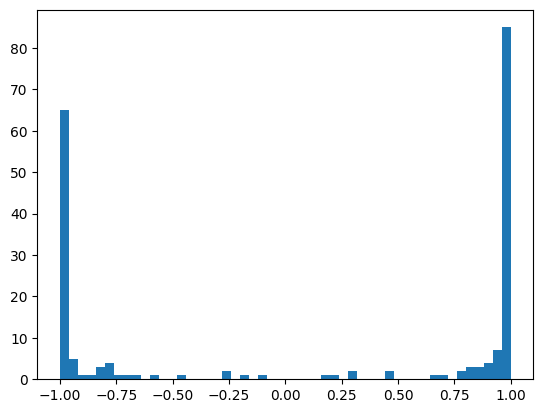

In [18]:
plt.hist(h.view(-1).tolist(), 50)

Most of the activations are at -1 or 1 at initialization. Remember the derivative of tanh? It was $(1-t**2)$. This means that when the activations are -1 or 1, then their gradient becomes zero. So, at initialization itself, these neurons become dead neurons. If the value of `t==0`, then you have maximum gradient, which is 1, i.e. the gradient just passes through. But in all other cases, the gradient decreases.

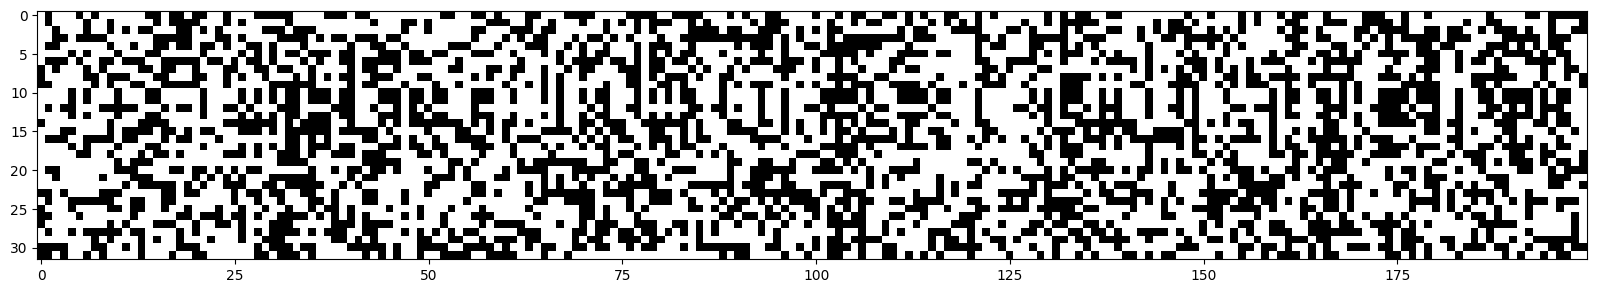

In [19]:
# White = True, Black = False
plt.figure(figsize=(20, 10))
plt.imshow(activations.abs() > 0.99, cmap='gray', interpolation='nearest')

All the white cells represent the instances where the tanh is giving extreme values. X-axis is the number of neurons. Y-axis is the sample.
If an entire column is white, that's a cause for big trouble. That means that for any of the input, the neuron didn't fire. If the neuron is not firing for any input, then it's a dead neuron.

Sigmoid, Tanh, ReLU are neurons where such situation can occur. At times, this happens during initialization. At times, this happens during optimization- when your learning rate is too high, for instance.

Here, at initialization, many neurons are not getting gradients, which is not good. So what can be done to improve on this?

#### Better Preactivations

The values of the preactivations are too extreme, that's what is being fed into the tanh and that is making the tanh go closer to -1 and 1. For instance, in the plot below, we see the values of preactivations are between [-20, 20], which is quite extreme. We can fix this by doing the same thing that we did for the activations- scale down the initial weights and biases.

(array([  3.,   3.,   1.,   5.,   7.,   9.,  12.,  27.,  25.,  40.,  48.,
         56.,  77., 108., 113., 134., 176., 275., 231., 308., 338., 358.,
        391., 391., 392., 346., 381., 344., 301., 296., 231., 185., 189.,
        147., 108.,  93.,  85.,  40.,  47.,  18.,  18.,  11.,   6.,  12.,
          4.,   4.,   1.,   2.,   1.,   2.]),
 array([-17.19238853, -16.47425137, -15.7561142 , -15.03797703,
        -14.31983986, -13.60170269, -12.88356552, -12.16542835,
        -11.44729118, -10.72915401, -10.01101685,  -9.29287968,
         -8.57474251,  -7.85660534,  -7.13846817,  -6.420331  ,
         -5.70219383,  -4.98405666,  -4.26591949,  -3.54778233,
         -2.82964516,  -2.11150799,  -1.39337082,  -0.67523365,
          0.04290352,   0.76104069,   1.47917786,   2.19731503,
          2.91545219,   3.63358936,   4.35172653,   5.0698637 ,
          5.78800087,   6.50613804,   7.22427521,   7.94241238,
          8.66054955,   9.37868671,  10.09682388,  10.81496105,
         11.533098

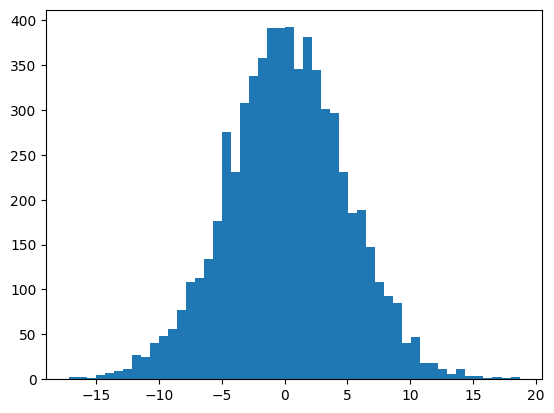

In [20]:
plt.hist(preactivations.view(-1).tolist(), 50)

In [21]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 1
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    break

(array([  1.,   0.,   0.,   0.,   1.,   0.,   2.,   1.,   1.,   2.,  12.,
          8.,  26.,  20.,  29.,  40.,  75., 105., 142., 173., 225., 286.,
        291., 387., 415., 475., 487., 481., 462., 403., 406., 328., 289.,
        231., 157., 115.,  90.,  71.,  64.,  32.,  18.,  13.,  13.,   9.,
          7.,   4.,   1.,   1.,   0.,   1.]),
 array([-2.56114149, -2.46598917, -2.37083686, -2.27568454, -2.18053223,
        -2.08537991, -1.99022759, -1.89507528, -1.79992296, -1.70477065,
        -1.60961833, -1.51446601, -1.4193137 , -1.32416138, -1.22900907,
        -1.13385675, -1.03870443, -0.94355212, -0.8483998 , -0.75324749,
        -0.65809517, -0.56294285, -0.46779054, -0.37263822, -0.2774859 ,
        -0.18233359, -0.08718127,  0.00797104,  0.10312336,  0.19827568,
         0.29342799,  0.38858031,  0.48373262,  0.57888494,  0.67403726,
         0.76918957,  0.86434189,  0.9594942 ,  1.05464652,  1.14979884,
         1.24495115,  1.34010347,  1.43525578,  1.5304081 ,  1.62556042,
 

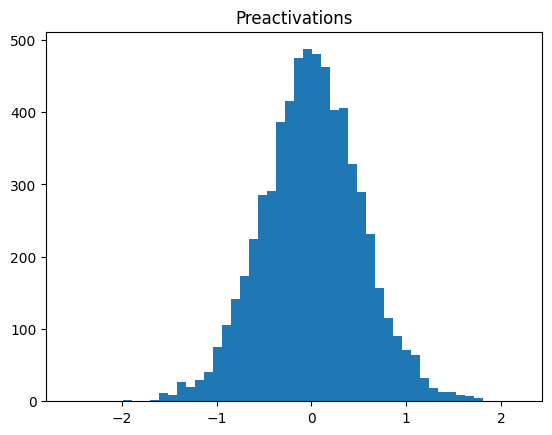

In [22]:

plt.title("Preactivations")
plt.hist(preactivations.view(-1).tolist(), 50)


(array([  5.,  14.,  33.,  35.,  44.,  52.,  83.,  94., 113., 119., 113.,
        136., 155., 142., 142., 140., 173., 188., 167., 197., 184., 197.,
        199., 197., 201., 219., 201., 185., 210., 176., 182., 183., 172.,
        185., 184., 174., 158., 146., 163., 124., 110., 102.,  82.,  81.,
         70.,  71.,  41.,  28.,  23.,   7.]),
 array([-0.98814589, -0.9488715 , -0.90959711, -0.87032272, -0.83104833,
        -0.79177394, -0.75249955, -0.71322516, -0.67395077, -0.63467638,
        -0.59540199, -0.5561276 , -0.51685321, -0.47757882, -0.43830443,
        -0.39903004, -0.35975565, -0.32048126, -0.28120687, -0.24193248,
        -0.20265809, -0.1633837 , -0.12410931, -0.08483492, -0.04556053,
        -0.00628614,  0.03298825,  0.07226264,  0.11153702,  0.15081141,
         0.1900858 ,  0.22936019,  0.26863458,  0.30790897,  0.34718336,
         0.38645775,  0.42573214,  0.46500653,  0.50428092,  0.54355531,
         0.5828297 ,  0.62210409,  0.66137848,  0.70065287,  0.73992726,
 

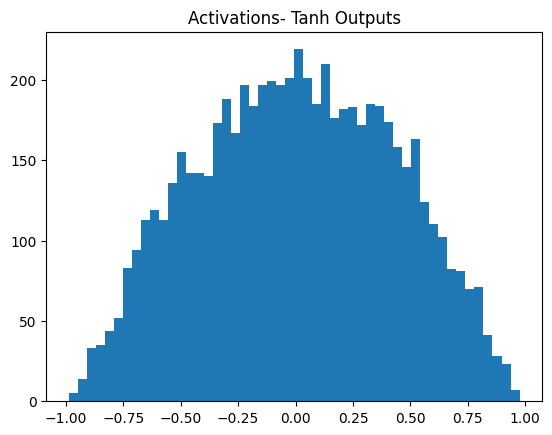

In [23]:
plt.title("Activations- Tanh Outputs")
plt.hist(activations.view(-1).tolist(), 50)

This is much better. We have a much less saturated tanh.

### Kaiming Initialization

We need some way to find out how to scale down the weight matrices- not by putting some random numbers and use them as scaling factors. 

X's mean and stdev is:  tensor(0.0016) tensor(1.0067)
W's mean and stdev is:  tensor(-0.0163) tensor(0.9774)


(array([1.49611122e-05, 7.48055610e-06, 2.99222244e-05, 8.22861171e-05,
        1.04727785e-04, 1.94494459e-04, 3.59066693e-04, 5.53561152e-04,
        8.75225064e-04, 1.44374733e-03, 2.07211404e-03, 3.21663912e-03,
        4.99701148e-03, 7.70497278e-03, 1.11909119e-02, 1.68536929e-02,
        2.42669240e-02, 3.38569969e-02, 4.73893229e-02, 6.35772463e-02,
        8.24806116e-02, 1.01428860e-01, 1.18626659e-01, 1.33273588e-01,
        1.39145824e-01, 1.36198485e-01, 1.23997698e-01, 1.08213725e-01,
        8.84126926e-02, 6.99880829e-02, 5.31418705e-02, 3.89138528e-02,
        2.71095353e-02, 1.94270042e-02, 1.25897759e-02, 9.02903121e-03,
        5.75254764e-03, 3.50838081e-03, 2.30401128e-03, 1.37642232e-03,
        9.57511181e-04, 5.68522264e-04, 2.39377795e-04, 2.46858351e-04,
        1.42130566e-04, 1.27169454e-04, 3.74027805e-05, 2.24416683e-05,
        2.24416683e-05, 3.74027805e-05]),
 array([-16.48653412, -15.81813461, -15.14973511, -14.4813356 ,
        -13.8129361 , -13.1445

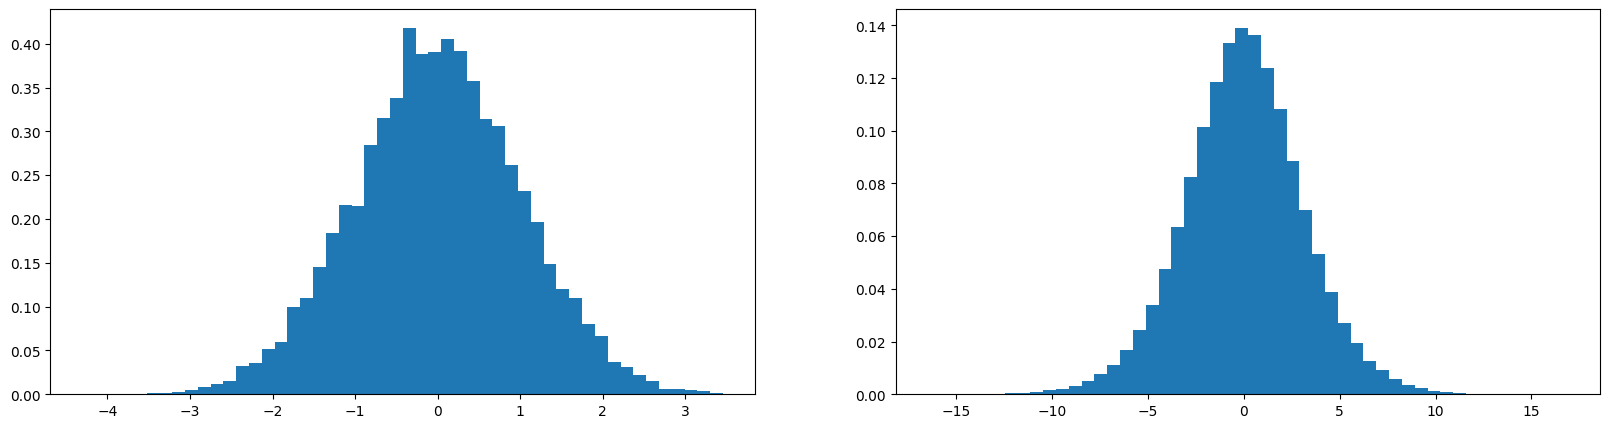

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)

print("X's mean and stdev is: ", x.mean(), x.std())
print("W's mean and stdev is: ", w.mean(), w.std())

y = x @ w

plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)

Notice that the input to the first layer is going to be `x`, and the input to the second layer is going to be `x @ w = y`. Observe how the mean stays the same after multiplication, but if the weights are high, the variance expands a lot! (If the weights are low, then the variance will shrink.)

We have assumed that `x` and `w` both come from standard gaussian distributions.

That is to say that after matrix multiplication the gaussian *expands*, and the inputs to deeper layers become more and more extreme. We don't want the variance to expand- we want a similar standard distribution of inputs even in deeper layers of the neural net. 

So we need a way to preserve the standard gaussian across layers.

One way to do this is as follows:

Divide the weight matrices by the square root of the inputs passed to the matrix, i.e. the first dim of the matrix.

For example:
```python
w = torch.randn(10, 200) / (10 ** 0.5)
```

If we initialize the weights well, backpropagation also works approximately good up to a constant factor. But in practice, this choice of whether to carefully initialize for the forward pass or for the backward pass doesn't matter that much. 

Kaiming Initialization is a good way to overcome the initialization issues. However, due to optimizers like ADAM and due to batch normalization, etc., initialization is not that big of an issue. 

Look up Kaiming Initialization, which is now the de facto way of initialization. 

For Tanh activations, you'd want to multiply the weight matrix by $\dfrac{5}{3}$ before you divide by the square root of fan_in.

**Pro Tip:** When Andrej initializes, he basically takes square root of the fan_in, i.e. the inputs of the matrix.

In [ ]:
# Since only W1 is going into Tanh, we'll kaiming init only W1
# Rest of the intializations, we'll keep them as is.
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

epochs = 10_000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 + b1
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

### Batch Normalization

Instead of focusing so much on intialization, we normalize the pre-activations to be unit Gaussian at least at initialization. After initialization, we want the model to decide whether the pre-activations should be unit Gaussian or some other distribution. 

Remember that this is not like a probability distribution, but rather you have a bunch of values that when put together resemble the standard bell curve. You have the liberty to add / multiply the *values* of the pre-activations by some numbers and get an entirely different distribution. That is, if you have 3 pre-activations, you can have 3 *scale* values that you multiply the pre-activations with, and you can have 3 *shift* values that you add the pre-activations with. This way, at initialization, we have Gaussian pre-activations but they don't have to be Gaussian throughout the training. 

Again, you want your model to learn these scale and shift values, and as Mitesh Sir likes to say, when you want the model to learn something, you introduce parameters. So we introduce new parameters for the scale and shift- *bngain* and *bnbias*.

Further, because you are adding the *bnbias*, the bias parameters *b1* become redundant, so we can get rid of them. Because intuitively, *bnbias* is going to learn the same bias as *b1*.

In [18]:
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# Introduce the scale and shift parameters
bn_bias = torch.zeros((1, n_hidden))
bn_gain = torch.ones((1, n_hidden))

parameters = [ C, W1, b1, W2, b2, bn_gain, bn_bias ]
for p in parameters:
    p.requires_grad = True

print(f"Number of parameters is: {sum(p.nelement() for p in parameters)}")

Number of parameters is: 12297


For inference time, we need to use the *bn_gain* and *bn_bias* that is an average of the entire training dataset. Without this, you will need to pass an entire batch for inference and you won't be able to pass a single input for prediction. So we define the running *bn_mean* and running *bn_bias*. In PyTorch, these are called *buffers*.

In [ ]:
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

In [ ]:
# Train the model
epochs = 10_000
batch_size = 32
lossi = [ ]

for i in range(epochs):

    # Construct the minibatch
    idxs = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    X_batch, y_batch = X_train[idxs], Y_train[idxs]

    # Forward pass
    embeddings = C[X_batch]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1) # Concatenate the embeddings
    preactivations = concatenated_embeddings @ W1 # Don't need the b1 biases here

    # Batch Normalization and running Mean
    bnmeani = preactivations.mean(0, keepdim=True)
    bnstdi = preactivations.std(0, keepdim=True)
    preactivations = bn_gain * (preactivations - bnmeani) / bnstdi + bn_bias
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bnmeani
        bn_std_running = 0.999 * bn_std_running + 0.001 * bnstdi # 0.001 is called "momentum" in PyTorch. Roughly: Large batch size => higher momentum is fine like 0.1

    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y_batch) # PyTorch will apply softmax internally

    for p in parameters:
        p.grad = None

    loss.backward()

    lr = 0.1 if i < 10_000 else 0.01

    for p in parameters:
        p.data -= lr * p.grad

    if i % 1000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

print("Loss: ", loss.item())

      0/  10000: 3.3224
   1000/  10000: 2.3477
   2000/  10000: 2.4604
   3000/  10000: 2.0222
   4000/  10000: 2.2599
   5000/  10000: 2.2993
   6000/  10000: 2.1970
   7000/  10000: 2.2350
   8000/  10000: 2.6630
   9000/  10000: 2.4127
Loss:  2.3850536346435547


In [ ]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': [X_train, Y_train], 
        'test': [X_test, Y_test], 
        'val': [X_val, Y_val]
    }[split]

    embeddings = C[x]
    concatenated_embeddings = embeddings.view(embeddings.shape[0], -1)
    preactivations = concatenated_embeddings @ W1 
    preactivations = bn_gain * (preactivations -  bn_mean_running) / bn_std_running + bn_bias
    activations = torch.tanh(preactivations)
    logits = activations @ W2 + b2 # Output layer

    loss = F.cross_entropy(logits, y) # PyTorch will apply softmax internally

    print(f"For {split}, loss was: {loss.item()}")

In [21]:
split_loss('train'), split_loss('val')

For train, loss was: 2.263530731201172
For val, loss was: 2.2691726684570312


(None, None)

Batch normalization makes the normalization of weights scalable. Instead of manually defining the gain for each linear layer, we can add batch normalization layers throughout the network and it achieves the same thing. Typically, after linear or convolutional layers, you add batch normalization.

#### Some Things to Keep in Mind About Batch Normalization

1. Because of BN, the logits and the preactivations are a function of not just the input `x` but the entire batch! ( Since you're taking mean and standard deviation and dividing by it). So for different batch, you're going to get different mean and standard deviation. As a result, there will be some noise while training- but in practice, this acts as a regularizer! This, at times, can cause bugs in your code.
2. But it's not ideal to have this property of an output being coupled with an entire batch. So there are now methods such as group normalization, layer normalization, etc. that try to overcome this. 

**Pro Tip:** 

In practice, when training deep neural networks, should you use ReLU or should you use Tanh? When training very deep neural nets, ReLU empiracally works better.

## PyTorch-ifying Code

In [ ]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in **0.5) # Divide by sqrt(fan_in)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps # Small number to avoid zero division error when normalization
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Not parameters- "buffers"
        self.running_mean = torch.ones(dim)
        self.running_var = torch.zeros(dim)

    def __call__(self, x:torch.Tensor):
        if self.training:
            xmean = x.mean(0, keepdim=True) # Batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # Batch variance

        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to zero mean and unit variance

        self.out = self.gamma * xhat +  self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []